In [217]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.utils.data as Data

In [218]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [219]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

In [220]:
data1 = cv2.imread('pos1_32x32.png')
data2= cv2.imread('pos2_32x32.png')

result = np.repeat(data1[np.newaxis,...], 20000, axis=0)
print(result.shape)
y0 = result.astype('float32')




result1 = np.repeat(data2[np.newaxis,...], 20000, axis=0)
y1 = result1.astype('float32')

y0 = y0[:,:,:,0]
y1 = y1[:,:,:,0]
print(y0.shape)

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)



torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=250,

    shuffle=True,

    num_workers=0,

)


(20000, 32, 32, 3)
(20000, 32, 32)


In [221]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=64
        )
        self.encoder_output_layer_1 = nn.Linear(
            in_features=64, out_features=32
        )
        self.encoder_output_layer_2 = nn.Linear(
            in_features=32, out_features=16
        )
        self.encoder_output_layer_3 = nn.Linear(
            in_features=16, out_features=8
        )


    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        code = self.encoder_output_layer_1(code)
        code = torch.relu(code)
        code = self.encoder_output_layer_2(code)
        code = torch.relu(code)
        code = self.encoder_output_layer_3(code)
        code = torch.sigmoid(code)
        return code

In [222]:
#  use gpu if available

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=1024)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)

    covf = torch.matmul((fx.t()), fx) / Nsamples

    covg = torch.matmul((gy.t()), (gy)) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h

In [223]:
for epoch in range(50):
    loss = 0
    for x,y in loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        #print(batch_features[0].shape)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        x = x.view(-1, 1024)
        y = y.view(-1, 1024)
        # compute reconstructions        
        # compute training reconstruction loss
        train_loss = h_score(model(x),model(y))
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.00000000
epoch : 2/20, recon loss = -0.00000000
epoch : 3/20, recon loss = 0.00000000
epoch : 4/20, recon loss = 0.00000000
epoch : 5/20, recon loss = 0.00000000
epoch : 6/20, recon loss = 0.00000000
epoch : 7/20, recon loss = -0.00000000
epoch : 8/20, recon loss = -0.00000000
epoch : 9/20, recon loss = -0.00000000
epoch : 10/20, recon loss = 0.00000000
epoch : 11/20, recon loss = 0.00000000
epoch : 12/20, recon loss = 0.00000000
epoch : 13/20, recon loss = 0.00000000
epoch : 14/20, recon loss = -0.00000000
epoch : 15/20, recon loss = 0.00000000
epoch : 16/20, recon loss = 0.00000000
epoch : 17/20, recon loss = 0.00000000
epoch : 18/20, recon loss = -0.00000000
epoch : 19/20, recon loss = -0.00000000
epoch : 20/20, recon loss = -0.00000000
epoch : 21/20, recon loss = -0.00000000
epoch : 22/20, recon loss = 0.00000000
epoch : 23/20, recon loss = -0.00000000
epoch : 24/20, recon loss = -0.00000000
epoch : 25/20, recon loss = -0.00000000
epoch : 26/20, recon l

In [225]:

test_loader = torch.utils.data.DataLoader(
    x, batch_size=200, shuffle=True
)

test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        test_examples = batch_features.view(-1, 1024)
        reconstruction = model(test_examples)
        
        break

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

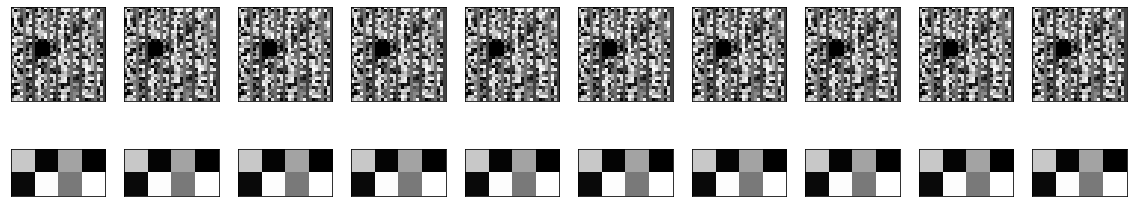

In [229]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(y0[index])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(2,4 ))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()